## Análise estatística ilustrando o uso do sistema BlueBikes de Boston

### Este caderno responde às seguintes questões:

#### - Quantas viagens ocorreram através dos anos?
#### - Qual é a distância média percorrida pelos usuários?
#### - Quanto tempo duram as viagens?
#### - Qual é a velocidade média de homens e mulheres?

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.dates as mdate
from shapely.geometry import Point
import geopandas as gpd
import folium
import math
import datetime as dt
import glob
from ipywidgets import interact_manual, widgets
from scipy.interpolate import CubicSpline
import seaborn as sbn
import warnings

import bikescience.load_trips as tr
import bikescience.charts as ch
import bikescience.distributions as dist
from IPython.core.display import display, HTML

pd.set_option('display.float_format', lambda x: '%.1f' % x)
# global settings for the charts
plt.rcParams['font.family'] = 'FreeSerif'
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 18
warnings.simplefilter('ignore')

## Carregando todas as viagens do BlueBikes de Julho de 2011 a Julho de 2019

In [2]:
#trips = tr.load_trips_file('../data/boston/bike-trips/201812-bluebikes-tripdata.csv')
trips = tr.load_all_trips('../data/boston/bike-trips')
#cleaning data to remove a station used only for tests without lat/long information, ID 164
trips = trips[(trips['end station latitude'] != 0) & 
              (trips['end station longitude'] != 0) &
              (trips['start station latitude'] != 0) & 
              (trips['start station longitude'] != 0)]
display(HTML('<div class=\"custom\"><h3>%s viagens</h3>'%(len(trips))))

In [3]:
stations = pd.read_csv('../data/boston/bike-stations/stations.csv')
display(HTML('<div class=\"custom\"><h3>%s estações em Boston</h3>'%(len(stations))))

##   Duração das viagens

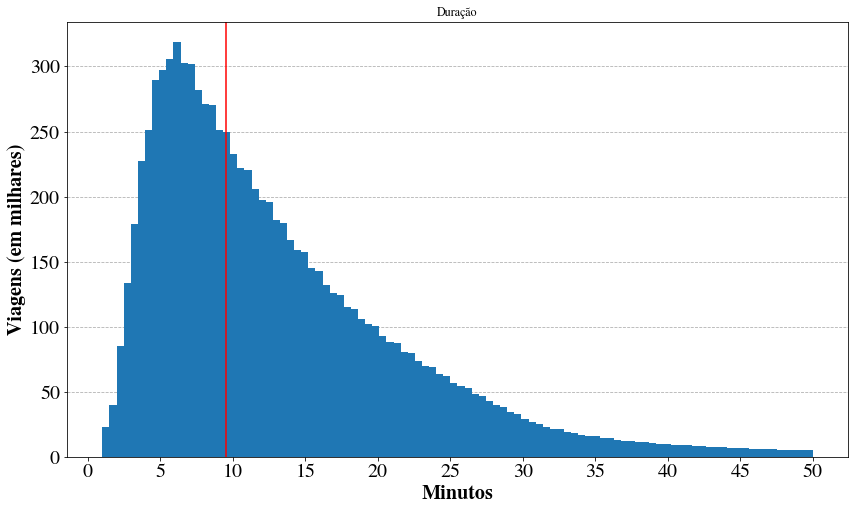

In [4]:
duration = trips[trips['tripduration'] < 3000]
duration = duration[['tripduration']]

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=5)

ax_duration = plt.axes()
ax_duration.set_axisbelow(True)
plt.grid(linestyle='--')
ax_duration.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_duration.yaxis.set_major_formatter(formatter)
ax_duration.xaxis.set_major_locator(loc)
plt.hist(bins=100,x=duration['tripduration']/60)
plt.title('Duração')
plt.xlabel('Minutos')
plt.ylabel('Viagens (em milhares)')
#fig_duration = plt.gcf()
plt.axvline(x=9.5,color='red')
plt.show()

## Tipo de usuário

In [5]:
subscribers = trips[trips['usertype'] == 'Subscriber']
customers = trips[trips['usertype'] == 'Customer']
display(HTML('<div class=\"custom\"><h3>Assinante: %s (%s)</h3>'%("{0:.2%}".format(len(subscribers) / len(trips)),len(subscribers))))
display(HTML('<div class=\"custom\"><h3>Avulso: %s (%s)</h3>'%("{0:.2%}".format(len(customers) / len(trips)),len(customers))))

## Gênero

In [6]:
male = trips[trips['gender'] == 1]
female = trips[trips['gender'] == 2]
unknown = trips[trips['gender'] == 0]
display(HTML('<div class=\"custom\"><h3>Homens: %s (%s)</h3>'%("{0:.2%}".format(len(male) / len(trips)),len(male))))
display(HTML('<div class=\"custom\"><h3>Mulheres: %s (%s)</h3>'%("{0:.2%}".format(len(female) / len(trips)),len(female))))
display(HTML('<div class=\"custom\"><h3>Desconhecido: %s (%s)</h3>'%("{0:.2%}".format(len(unknown) / len(trips)),len(unknown))))

## Distância

Usando o algoritmo GraphHoper

In [8]:
stations_distances = pd.read_csv('../data/boston/bike-stations/stations_distances.csv', index_col=['id_x', 'id_y'])
merge = trips.merge(stations_distances, left_on=['start station id', 'end station id'], right_index=True)
merge['speed'] = merge['distance']/merge['tripduration']*3600

### Distância (ignorando viagens circulares)

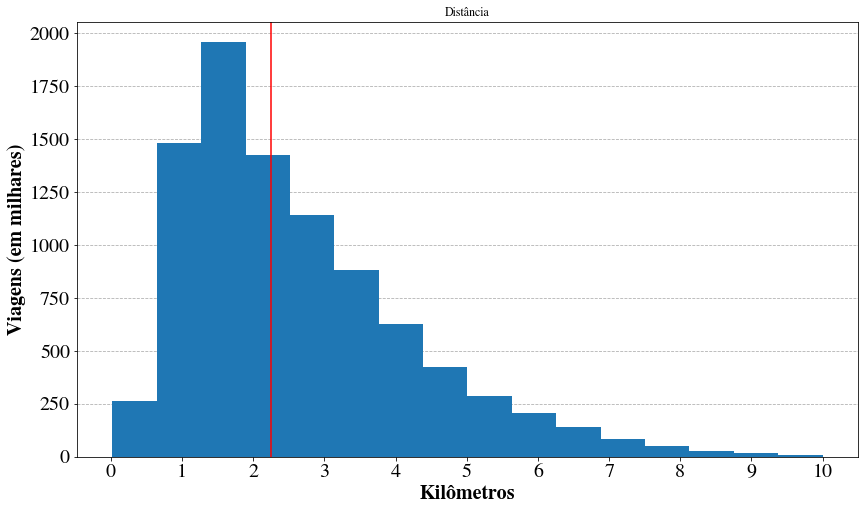

In [9]:
distance = merge[(merge.distance<10) & (merge.distance>0)]

distance = distance[['distance']]

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=1)

ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_distance.yaxis.set_major_formatter(formatter)
ax_distance.xaxis.set_major_locator(loc)
plt.hist(bins=16,x=distance['distance'])
plt.title('Distância')
plt.xlabel('Kilômetros')
plt.ylabel('Viagens (em milhares)')
plt.axvline(x=distance['distance'].median(),color='red')
#fig_distance = plt.gcf()
plt.show()

## Velocidade: Mulheres são um pouco menos apressadas :-)


In [10]:
gender = merge
gender = gender[gender.distance < 50]
gender.reset_index(inplace=True)
gender = gender[['gender','distance','tripduration','speed']]

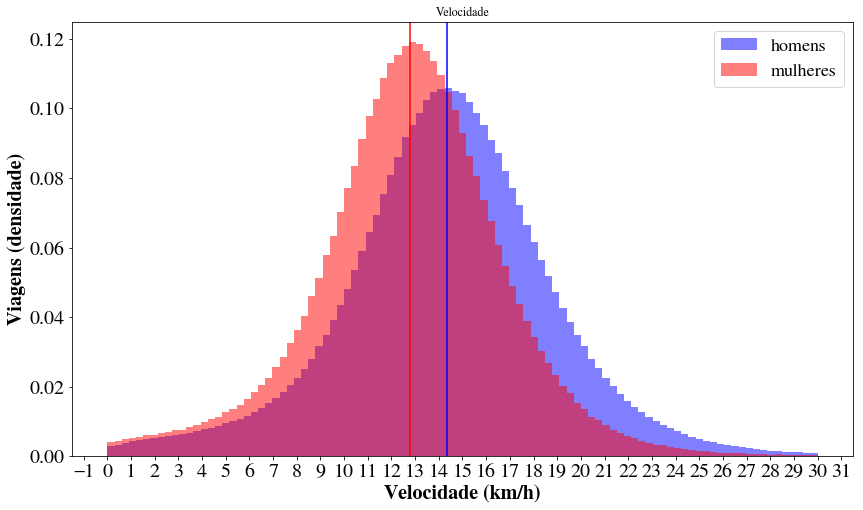

In [11]:
women_speed = gender[(gender.gender == 2) & (gender.speed> 0) & (gender.speed < 30)].speed
men_speed   = gender[(gender.gender == 1) & (gender.speed> 0) & (gender.speed < 30)].speed

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=1)

bins = np.linspace(0, 30, 100)
ax_gender = plt.axes()
ax_gender.xaxis.grid(False)
ax_gender.yaxis.grid(False)
ax_gender.xaxis.set_major_locator(loc)
plt.hist(men_speed, bins, alpha=0.5, label='homens', density=True, color='blue')
plt.hist(women_speed, bins, alpha=0.5, label='mulheres', density=True, color='red')
plt.legend(loc='upper right')
plt.title('Velocidade')
plt.axvline(x=women_speed.mean(),color='red')
plt.axvline(x=men_speed.mean(),color='blue')
plt.xlabel('Velocidade (km/h)')
plt.ylabel('Viagens (densidade)')
plt.show()

In [12]:
#boxplots
plt.figure(figsize=(10,6))
plt.xlabel('Gênero')
plt.ylabel('Velocidade (km/h)')
plt.boxplot([women_speed,men_speed],showfliers=False)
plt.xticks([1,2],['mulheres','homens'])
pos=[1,2]

### Viagens por mês e gênero - média de uso diária e desvio padrão de Julho de 2011 a Julho de 2019

In [13]:
trip_time_series = trips[['starttime', 'gender']]
trip_time_series = \
        trip_time_series[(trip_time_series.starttime < pd.Timestamp('2019-08-01 00:00:0000'))]
trip_time_series.set_index(pd.DatetimeIndex(trip_time_series['starttime']), inplace=True)

### Obtendo a média diária por mês

In [14]:
trips_day_average = trip_time_series['starttime'].groupby(pd.Grouper(freq='D')).count()
trips_per_month = trips_day_average.groupby(pd.Grouper(freq='MS')).agg({'mean':'mean','std':'std'})

### Calculando o percentual de viagens de mulheres

In [15]:
#women bike usage percentage
women_trips = trip_time_series[(trip_time_series.gender == 2)]
men_trips = trip_time_series[(trip_time_series.gender == 1)]

women_trips_day_count = women_trips['starttime'].groupby(pd.Grouper(freq='D')).count()
men_trips_day_count = men_trips['starttime'].groupby(pd.Grouper(freq='D')).count()

women_trips_per_month = women_trips_day_count.groupby(pd.Grouper(freq='MS')).agg({'sum':'sum'})
men_trips_per_month = men_trips_day_count.groupby(pd.Grouper(freq='MS')).agg({'sum':'sum'})

women_percentage_per_month = women_trips_per_month.copy()
men_percentage_per_month = men_trips_per_month.copy()

women_percentage_per_month['percentage'] = \
    women_percentage_per_month['sum']/(women_percentage_per_month['sum']+men_percentage_per_month['sum'])*100

### Calculando a média dos 12 meses anteriores

In [20]:
trips_12_month_rolling = trips_per_month.sort_index().rolling(12).mean().dropna()
trips_12_month_rolling.head(5)

mean   std
starttime              
2012-06-01  893.7 324.0
2012-07-01 1025.2 329.9
2012-08-01 1155.2 327.3
2012-09-01 1273.4 351.9
2012-10-01 1381.7 377.4

### Série temporal - viagens

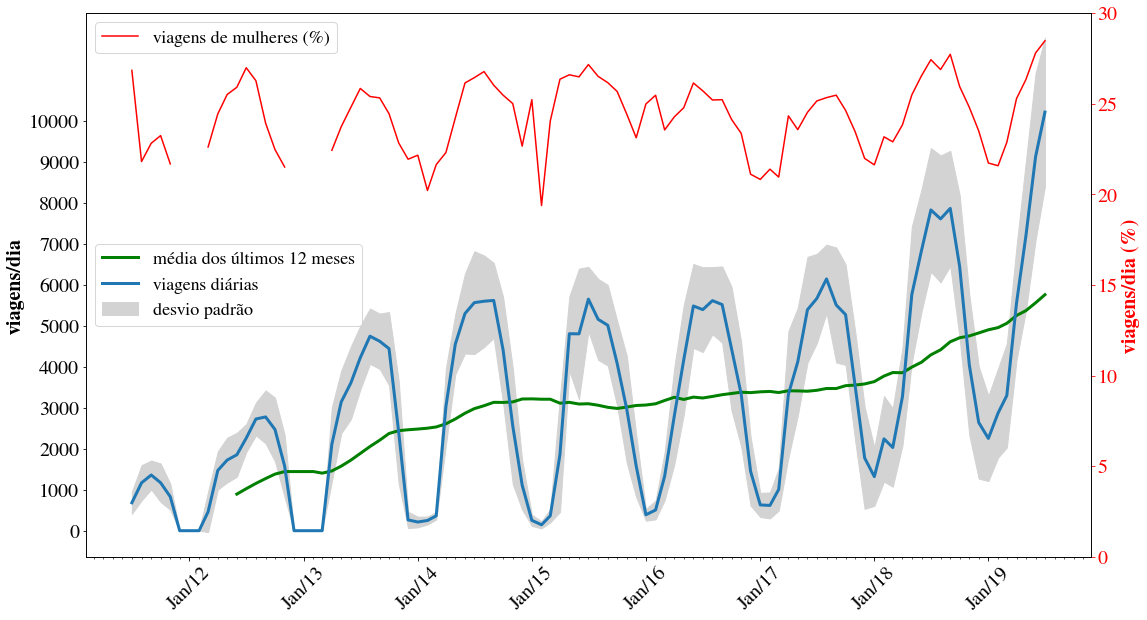

In [21]:
dateFmt = mdate.DateFormatter('%b/%y')

ax_day_avg_gender = plt.axes()
ax_day_avg_gender.set_axisbelow(True)
ax_day_avg_gender.xaxis.grid(False)
ax_day_avg_gender.yaxis.grid(False)
ax_day_avg_gender.plot(trips_12_month_rolling['mean'],label='média dos últimos 12 meses',linewidth=3,color='green')
ax_day_avg_gender.plot(trips_per_month['mean'], label='viagens diárias', linewidth=3)
ax_day_avg_gender.figure.set_size_inches(18,10)
ax_day_avg_gender.xaxis.set_major_formatter(dateFmt)
ax_day_avg_gender.xaxis.set_minor_locator(mdate.MonthLocator())

plt.ylabel('viagens/dia')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,10001,step=1000))
plt.fill_between(trips_per_month.index,trips_per_month['mean']-trips_per_month['std'],
                 trips_per_month['mean']+trips_per_month['std'],color='lightgray',label='desvio padrão')
plt.legend(loc='center left')

ax_perc_women = ax_day_avg_gender.twinx()
ax_perc_women.plot(women_percentage_per_month.index,women_percentage_per_month['percentage'],label='viagens de mulheres (%)',color='red')
ax_perc_women.set_ylabel('viagens/dia (%)', color='red')
ax_perc_women.yaxis.grid(False)
ax_perc_women.xaxis.set_major_formatter(dateFmt)
ax_perc_women.set_yticks(np.arange(0,30.1,step=5))
ax_perc_women.legend(loc='upper left')
ax_perc_women.tick_params('y',colors='red')

plt.savefig('charts/Trips-Evolution.pdf', format='pdf', dpi=200)
plt.draw()

## Padrão diário de viagens por estação e por tipo de uso (partida ou chegada)
### Selecione a estação desejada e o tipo de uso

In [17]:
def trip_daily_pattern(station, trip_point):
    print('Calculando...')
    station_id = stations[stations['sname'] == station].index[0]
    day_counts = merge[merge[trip_point+' station id'] == station_id] \
          [['hour', 'weekend', 'per_day']].drop_duplicates() \
          .groupby(['hour', 'weekend'], as_index=False).agg({'per_day': 'count'})
    trip_counts = merge[merge[trip_point+' station id'] == station_id] \
                .groupby(['hour', 'weekend'], as_index=False).agg({'tripduration': 'count'})
    counts = day_counts.merge(trip_counts, on=['hour', 'weekend'])
    counts.rename(columns={'per_day': 'day_count', 'tripduration': 'trip_count'}, inplace=True)
    counts['daily_mean'] = counts['trip_count'] / counts['day_count']
    
    plt.figure(figsize=(20, 8))
    width=0.5
        
    for t in [False, True]:
        filtered = counts[counts['weekend'] == t]
        y = filtered['daily_mean']
        x = filtered['hour']
        if len(x) > 0:
            plt.bar(x-width/2 if t else x+width/4, y, width=width, label='fins de semana' if t else 'dias úteis')
        if len(x) >= 2:  # mininum for spline generation
            spline = CubicSpline(x, y)
            x_vals = np.linspace(x.min(), x.max(), 500, dtype=np.float64)
            y_smooth = spline(x_vals)
            plt.plot(x_vals, y_smooth)
        
    plt.xlabel('Hora')
    plt.ylabel('Média diária')
    plt.legend()
    print('Feito.')
    plt.show()
    
im = interact_manual(
    trip_daily_pattern,
    station=widgets.Dropdown(options=stations['sname'].sort_values(), value='MIT at Mass Ave / Amherst St'),
    trip_point=widgets.RadioButtons(options=['start', 'end'])
)
im.widget.children[2].description = 'Mostrar gráfico' 

interactive(children=(Dropdown(description='station', index=189, options=('18 Dorrance Warehouse', '30 Dane St…

## Lista de viagens por estação (partida e chegada)

Contagem de viagens:

In [18]:
#trips
trips_by_day = trips.groupby(['start station name'], as_index=False).agg({'tripduration': 'count'})
trips_by_day.columns = ['start station name', 'trip count']
trips_by_day.set_index('start station name',inplace=True)
trips_by_day.sort_values('trip count', ascending=False).head(10)

trip count
start station name                                            
MIT at Mass Ave / Amherst St                            260690
Central Square at Mass Ave / Essex St                   176426
South Station - 700 Atlantic Ave                        175573
MIT Stata Center at Vassar St / Main St                 171082
Harvard Square at Mass Ave/ Dunster                     159318
Ames St at Main St                                      123967
Copley Square - Dartmouth St at Boylston St             117585
One Kendall Square at Hampshire St / Portland St        113939
Beacon St at Massachusetts Ave                          109745
Lafayette Square at Mass Ave / Main St / Columb...      104007

In [19]:
#trips
trips_by_day = trips.groupby(['end station name'], as_index=False).agg({'tripduration': 'count'})
trips_by_day.columns = ['end station name', 'trip count']
trips_by_day.set_index('end station name',inplace=True)
trips_by_day.sort_values('trip count', ascending=False).head(10)

trip count
end station name                                              
MIT at Mass Ave / Amherst St                            255127
MIT Stata Center at Vassar St / Main St                 202514
Central Square at Mass Ave / Essex St                   174599
South Station - 700 Atlantic Ave                        171469
Harvard Square at Mass Ave/ Dunster                     168416
Ames St at Main St                                      124915
Copley Square - Dartmouth St at Boylston St             124764
One Kendall Square at Hampshire St / Portland St        106852
Lafayette Square at Mass Ave / Main St / Columb...      103052
Beacon St at Massachusetts Ave                          101920